# INIT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from tools_analysis import *

sns.set_theme()

In [2]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [3]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset_thres1.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer, if I comment it, all the TRACULA tracts will be removed
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(_c0_|_c1_|_f0_|_f1_|nTracts|voxVol)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

X = df.drop(["resp", "respPart"], axis=1)
X = X.filter(regex=r'(mean|age|duration|sex)')
y = df["respPart"]

(19, 7528)
(18, 5690)


# Logistic Regression

#### Scaling pruning

In [5]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.294 | Pr: 0.282 | Re: 0.360 | AUC: 0.510 | Accuracy: 0.360 | B_Acc: 0.360 

MinMaxScaler
F1: 0.305 | Pr: 0.293 | Re: 0.372 | AUC: 0.521 | Accuracy: 0.372 | B_Acc: 0.372 

Normalizer
F1: 0.345 | Pr: 0.313 | Re: 0.427 | AUC: 0.590 | Accuracy: 0.427 | B_Acc: 0.427 

Normalizer
F1: 0.408 | Pr: 0.411 | Re: 0.466 | AUC: 0.652 | Accuracy: 0.466 | B_Acc: 0.466 



#### Hyper parm pruning

In [6]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        class_weight="balanced",
        random_state=7,
        solver="lbfgs",
        multi_class="multinomial",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=100000,
                                                           multi_class='multinomial',
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [8]:
print("balanced_accuracy")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

balanced_accuracy
[0.80434008 0.80630595 0.81459722 0.82335556 0.84888056 0.86487302
 0.9171619  0.92568611 0.92774841 0.9236869  0.93489762 0.94482897
 0.94474722]
[0.23701853 0.23605237 0.23629203 0.23689575 0.2385903  0.23673838
 0.24692617 0.24919042 0.25524629 0.25333707 0.26066361 0.26816021
 0.2693809 ]
[13 12 11 10  9  8  7  5  4  6  3  1  2]


[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

Ho provato con normalizer l1 è le prestazioni non sono buone quante lo standard scaler.

#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        C=1e-6,
        )

l2
F1: 0.856 | Pr: 0.997 | Re: 1.000 | AUC: 0.998 | Accuracy: 0.831 



LogisticRegression(C=1e-06, class_weight='balanced', dual=True, max_iter=100000,
                   random_state=7, solver='liblinear')

#### Do again hyper parameter pruning with the selected features

In [16]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        class_weight="balanced",
        random_state=7,
        solver="lbfgs",
        multi_class="multinomial",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [17]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.83621429 1.84577381 1.85691071 1.85691071 1.85714286 1.85714286
 1.85714286 1.85714286 1.85714286 1.85714286 1.85714286 1.85714286
 1.85714286]
[7.45274569e-02 5.18752305e-02 7.33733029e-03 7.33733029e-03
 4.44089210e-16 4.44089210e-16 4.44089210e-16 4.44089210e-16
 4.44089210e-16 4.44089210e-16 4.44089210e-16 4.44089210e-16
 4.44089210e-16]
[13 12 10 10  1  1  1  1  1  1  1  1  1]


#### Display decision boundary

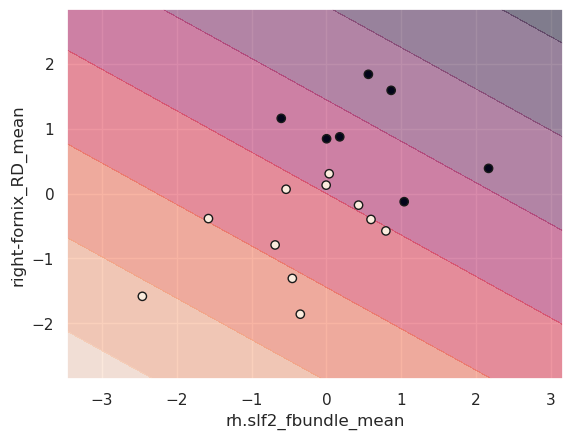

In [58]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['rh.slf2_fbundle_mean', 'right-fornix_RD_mean']])

log_reg = LogisticRegression(
    penalty="l2",
    C=1e-6,
    dual=True,
    class_weight="balanced",
    random_state=7,
    solver="liblinear",
    max_iter=100000,
)

log_reg.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_scaled,
    response_method="predict_proba",
    xlabel='rh.slf2_fbundle_mean',
    ylabel='right-fornix_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

# SVM kernel

#### Scaling pruning

In [4]:
# Scaling pruning 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

print("Linear")
for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    run_svm_kernel_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        kernel="linear"
    )

print("Poly")
for degree in [1, 2, 3]:
    print("Degree: ", degree)
    for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
        print(scaler.__class__.__name__)
        run_svm_kernel_cv(
            X, 
            y,
            StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
            pipeline=scaler,
            kernel = "poly",
            degree=degree,
        )
        
print("RBF")
for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    run_svm_kernel_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
    )

Linear
StandardScaler
F1: 0.289 | Pr: 0.287 | Re: 0.353 | AUC: 0.492 | Accuracy: 0.353 | B_Acc: 0.353  

MinMaxScaler
F1: 0.287 | Pr: 0.288 | Re: 0.350 | AUC: 0.484 | Accuracy: 0.350 | B_Acc: 0.350  

Normalizer
F1: 0.167 | Pr: 0.111 | Re: 0.333 | AUC: 0.406 | Accuracy: 0.333 | B_Acc: 0.333  

Normalizer
F1: 0.156 | Pr: 0.128 | Re: 0.224 | AUC: 0.341 | Accuracy: 0.224 | B_Acc: 0.224  

Poly
Degree:  1
StandardScaler
F1: 0.224 | Pr: 0.219 | Re: 0.279 | AUC: 0.469 | Accuracy: 0.279 | B_Acc: 0.279  

MinMaxScaler
F1: 0.205 | Pr: 0.197 | Re: 0.257 | AUC: 0.457 | Accuracy: 0.257 | B_Acc: 0.257  

Normalizer
F1: 0.197 | Pr: 0.162 | Re: 0.292 | AUC: 0.352 | Accuracy: 0.292 | B_Acc: 0.292  

Normalizer
F1: 0.156 | Pr: 0.130 | Re: 0.222 | AUC: 0.345 | Accuracy: 0.222 | B_Acc: 0.222  

Degree:  2
StandardScaler
F1: 0.196 | Pr: 0.168 | Re: 0.280 | AUC: 0.382 | Accuracy: 0.280 | B_Acc: 0.280  

MinMaxScaler
F1: 0.278 | Pr: 0.278 | Re: 0.338 | AUC: 0.469 | Accuracy: 0.338 | B_Acc: 0.338  

Normaliz

#### Hyperparam tuning

In [10]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        probability=True,
        kernel="linear",
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovo",
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            decision_function_shape='ovo',
                                            kernel='linear', probability=True,
                                            random_state=7))]),
             n_jobs=-1,
             param_grid={'svc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                    0.0005, 0.0001, 5e-05, 1e-05, 5e-06,
                                    1e-06]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [11]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.78034484 0.78034484 0.78034484 0.78034484 0.78034484 0.78034484
 0.7317877  0.62965278 0.56705516 0.57863611 0.607625   0.608
 0.58470833]
[0.24041409 0.24041409 0.24041409 0.24041409 0.24041409 0.24047667
 0.26452203 0.22700067 0.18639561 0.16246576 0.14145272 0.14154122
 0.14398779]
[ 1  1  1  1  1  1  7  8 13 12 10  9 11]


In [ ]:
"""
f1 + auc score
[0.78034484 0.78034484 0.78034484 0.78034484 0.78034484 0.78034484
 0.7317877  0.62965278 0.56705516 0.57863611 0.607625   0.608
 0.58470833]
[0.24041409 0.24041409 0.24041409 0.24041409 0.24041409 0.24047667
 0.26452203 0.22700067 0.18639561 0.16246576 0.14145272 0.14154122
 0.14398779]
[ 1  1  1  1  1  1  7  8 13 12 10  9 11]
"""

In [12]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        probability=True,
        kernel="poly",
        degree=3,
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovo",
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            decision_function_shape='ovo',
                                            kernel='poly', probability=True,
                                            random_state=7))]),
             n_jobs=-1,
             param_grid={'svc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                    0.0005, 0.0001, 5e-05, 1e-05, 5e-06,
                                    1e-06]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [13]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.68303294 0.64720278 0.57807817 0.57109405 0.56583254 0.56913095
 0.57675    0.57675    0.596125   0.596125   0.596125   0.596125
 0.58466667]
[0.23044587 0.20123407 0.17359481 0.17496856 0.15993102 0.15526395
 0.14847042 0.14847042 0.14754208 0.14754208 0.14754208 0.14754208
 0.15262163]
[ 1  2  8 11 13 12  9  9  3  3  3  3  7]


In [ ]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    "svc__gamma" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        probability=True,
        kernel="rbf",
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovo",
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

# Gaussian Naive Bayes

#### Scaling pruning

In [4]:
# Scaling pruning 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_gaussian_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.320 | Pr: 0.298 | Re: 0.426 | AUC: 0.572 | Accuracy: 0.426 | B_Acc: 0.426  

MinMaxScaler
F1: 0.320 | Pr: 0.298 | Re: 0.426 | AUC: 0.573 | Accuracy: 0.426 | B_Acc: 0.426  

Normalizer
F1: 0.277 | Pr: 0.251 | Re: 0.382 | AUC: 0.558 | Accuracy: 0.382 | B_Acc: 0.382  

Normalizer
F1: 0.297 | Pr: 0.251 | Re: 0.393 | AUC: 0.532 | Accuracy: 0.393 | B_Acc: 0.393  

RobustScaler
F1: 0.320 | Pr: 0.298 | Re: 0.426 | AUC: 0.572 | Accuracy: 0.426 | B_Acc: 0.426  



# KNN

#### Scaling pruning

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_knn_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.396 | Pr: 0.374 | Re: 0.473 | AUC: 0.601 | Accuracy: 0.473 | B_Acc: 0.473  

MinMaxScaler
F1: 0.403 | Pr: 0.381 | Re: 0.479 | AUC: 0.615 | Accuracy: 0.479 | B_Acc: 0.479  

Normalizer
F1: 0.351 | Pr: 0.326 | Re: 0.432 | AUC: 0.629 | Accuracy: 0.432 | B_Acc: 0.432  

Normalizer
F1: 0.368 | Pr: 0.334 | Re: 0.452 | AUC: 0.656 | Accuracy: 0.452 | B_Acc: 0.452  



#### Hyperpar tuning

In [6]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "kneighborsclassifier__n_neighbors" : [1, 2, 3, 4, 5, 6, 7, 11, 13],
}

pipe = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(
        weights="distance",
        n_jobs=-1
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 316, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packag

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1,
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 11, 13]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [7]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.83499405 0.87138988 0.99674464 0.98625317 0.95487381 0.90856825
 0.844175   0.75262063        nan]
[0.26117134 0.26164656 0.25765216 0.24633571 0.25724426 0.26108539
 0.25846058 0.20885826        nan]
[7 5 1 2 3 4 6 8 9]


# Decision tree

#### Scaling pruning

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_tree_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.337 | Pr: 0.337 | Re: 0.393 | AUC: 0.545 | Accuracy: 0.393 | B_Acc: 0.393  

MinMaxScaler
F1: 0.337 | Pr: 0.337 | Re: 0.393 | AUC: 0.545 | Accuracy: 0.393 | B_Acc: 0.393  

Normalizer
F1: 0.253 | Pr: 0.237 | Re: 0.302 | AUC: 0.477 | Accuracy: 0.302 | B_Acc: 0.302  

Normalizer
F1: 0.377 | Pr: 0.394 | Re: 0.424 | AUC: 0.569 | Accuracy: 0.424 | B_Acc: 0.424  

RobustScaler
F1: 0.337 | Pr: 0.337 | Re: 0.393 | AUC: 0.545 | Accuracy: 0.393 | B_Acc: 0.393  



#### Hyperparam tuning

In [9]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "decisiontreeclassifier__max_depth" : [2, 3, 5],
    "decisiontreeclassifier__min_samples_split" : [2, 3],
    "decisiontreeclassifier__min_samples_leaf" : [1, 2],
    "decisiontreeclassifier__min_weight_fraction_leaf" : [0.0, 0.25]
}

pipe = make_pipeline(
    StandardScaler(), 
    DecisionTreeClassifier(
        criterion="gini",
        splitter="best",
        max_features=None,
        random_state=7,
        class_weight="balanced",
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=7))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2],
                         'decisiontreeclassifier__min_samples_split': [2, 3],
                         'decisiontreeclassifier__min_weight_fraction_leaf': [0.0,
                                                                              0.25]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [10]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.88368036 0.88368036 0.88368036 0.88368036 0.88368036 0.88368036
 0.88368036 0.88368036 0.88182619 0.88368036 0.88182619 0.88368036
 0.88162817 0.88368036 0.88162817 0.88368036 0.88182619 0.88368036
 0.88182619 0.88368036 0.88162817 0.88368036 0.88162817 0.88368036]
[0.28264592 0.28264592 0.28264592 0.28264592 0.28264592 0.28264592
 0.28264592 0.28264592 0.2802263  0.28264592 0.2802263  0.28264592
 0.28091038 0.28264592 0.28091038 0.28264592 0.2802263  0.28264592
 0.2802263  0.28264592 0.28091038 0.28264592 0.28091038 0.28264592]
[ 1  1  1  1  1  1  1  1 17  1 17  1 21  1 21  1 17  1 17  1 21  1 21  1]


In [ ]:
"""
f1 + auc score
[0.88368036 0.88368036 0.88368036 0.88368036 0.88368036 0.88368036
 0.88368036 0.88368036 0.88182619 0.88368036 0.88182619 0.88368036
 0.88162817 0.88368036 0.88162817 0.88368036 0.88182619 0.88368036
 0.88182619 0.88368036 0.88162817 0.88368036 0.88162817 0.88368036]
[0.28264592 0.28264592 0.28264592 0.28264592 0.28264592 0.28264592
 0.28264592 0.28264592 0.2802263  0.28264592 0.2802263  0.28264592
 0.28091038 0.28264592 0.28091038 0.28264592 0.2802263  0.28264592
 0.2802263  0.28264592 0.28091038 0.28264592 0.28091038 0.28264592]
[ 1  1  1  1  1  1  1  1 17  1 17  1 21  1 21  1 17  1 17  1 21  1 21  1]
"""